# PELT integration test

Test the penalized exact linear time method for inferring changepoints. This is based on a PELT variant in which we minimize a cost function based on a KL divergence between the observed data distribution and a Bernoulli posterior for the latent state with piecewise-constant probability $p$.

## Load data

In [1]:
using HDF5

fid = h5open("data/basic_poisson_test.jld", "r")
λ = read(fid["base_rate"])
ν = read(fid["rate_gain"])
dt = read(fid["bin_width"])
counts = read(fid["counts"])
states = read(fid["states"]);

## Plot data

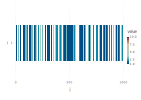

In [2]:
using Gadfly

spy(counts')

# Define some useful functions

In [3]:
# given start and end times t1 and t2, get sufficient statistics 
# for data between them
function grab_ss(t1, t2)
    this_counts = slice(counts, t1:t2)
    (sum(this_counts), length(this_counts))::Tuple{Int64, Int64}
end

grab_ss (generic function with 1 method)

In [4]:
function base_LL(t1, t2)
    this_counts = slice(counts, t1:t2)
    sum(Float64[c * log(λ * dt) - c * λ * dt - lfact(c) for c in this_counts])
end

base_LL (generic function with 1 method)

In [5]:
function κ(N::Int64, ℓ::Int64)
    (N * log(ν) - λ * dt * (ν - 1) * ℓ)::Float64
end

κ (generic function with 1 method)

In [6]:
function C(t1::Int64, t2::Int64)
    N, ℓ = grab_ss(t1, t2)
    kap = κ(N, ℓ)
    -(base_LL(t1, t2) + kap + log1p(exp(-kap)))::Float64
end

C (generic function with 1 method)

# Run inference

In [7]:
T = length(counts)  # number of time points
F = Array{Float64}(T + 1)  # F(t) = minimum cost for all data up to time t
R = Set{Int64}()  # set of times over which to search
CP = Set{Int64}()  # list of changepoints (ordered)
β = 2.  # penalty per changepoint
K = 0.0  # bound constant for objective gain on inserting changepoint

0.0

Now, initialize $F(0)$ and $R$:

In [8]:
push!(R, 0)
F[1] = -β

-2.0

In [9]:
for τ in 1:T
    mincost = Inf
    new_τ = 0
    for t in R
        cost = F[t + 1] + C(t + 1, τ) + β
        if cost < mincost
            mincost = cost
            new_τ = t
        end
    end
    F[τ + 1] = mincost
    
    #costs = Float64[F[t + 1] + C(t + 1, τ) + β for t in R]
    #F[τ + 1] = minimum(costs)
    #new_τ = indmin(costs) - 1
    push!(CP, new_τ)
    R = filter(t -> F[t + 1] + C(t + 1, τ) + K < F[τ + 1], R)
    push!(R, τ)
end

In [10]:
length(R)

14

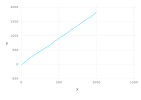

In [11]:
plot(x=collect(1:T + 1), y=F, Geom.line)

In [12]:
cplist = sort(Int64[s for s in CP]);
Ncp = length(cplist)
inferred = Array(Float64, T + 1)
for τ in 1:Ncp
    run_start = cplist[τ] + 1
    run_end = (τ == Ncp)? T : cplist[τ + 1]
    kap = κ(grab_ss(run_start, run_end)...)
    Ez = 1 / (1 + exp(-kap))
    inferred[run_start:run_end] = Ez
end

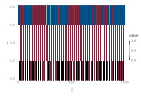

In [13]:
spy(vcat(inferred[1:(end - 1)]', states', counts'), 
    Scale.color_continuous(minvalue=0, maxvalue=1))

In [14]:
cplist

127-element Array{Int64,1}:
   0
  14
  17
  22
  32
  37
  53
  64
  72
  82
  94
  99
 103
   ⋮
 904
 911
 921
 928
 932
 943
 951
 960
 964
 969
 980
 988